In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy, mse
from keras.optimizers import Adam
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 100
epochs = 10
stats = []

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [6]:
x = Input(shape=input_shape)
h = Conv2D(32, (3, 3), activation='relu')(x)
h = Conv2D(64, (3, 3), activation='relu')(h)
h = MaxPooling2D(pool_size=(2, 2))(h)
h = Dropout(0.25)(h)
h = Flatten()(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.5)(h)
p = Dense(num_classes, activation='softmax')(h)
b = Dense(1)(h)
a = Input(shape=(1,))
model = Model([x, a], [p, b])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 26, 26, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 24, 24, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 12, 12, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [7]:
def policy_gradient_loss(y_true, y_pred):
    return a * sparse_categorical_crossentropy(y_true, y_pred)[:, np.newaxis]

model.compile(loss=[policy_gradient_loss, mse],
              optimizer=Adam(lr=0.0005))

In [8]:
for n in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:(i + batch_size)]
        y_batch = y_train[i:(i + batch_size)]

        # predict class probabilities
        a = np.zeros((x_batch.shape[0], 1))
        y_preds, baselines = model.predict([x_batch, a])

        # sample from those probabilities
        y_sample = np.empty((batch_size,), dtype=np.integer)
        for j, p in enumerate(y_preds):
            y_sample[j] = np.random.choice(num_classes, p=p)

        # calculate accuracy for logging
        y_preds = np.argmax(y_preds, axis=1)
        accuracy = np.mean(y_preds == y_batch)
        baseline = np.mean(baselines)

        # calculate reward and advantage, update baseline
        rewards = (y_sample == y_batch)[:, np.newaxis]
        advantages = rewards - baselines

        # train with samples as targets and advantage as sample weight
        losses = model.train_on_batch([x_batch, advantages], [y_sample, rewards])

        # log statistics
        stats.append(losses + [accuracy, baseline])
        print(i, losses, accuracy, baseline)

(0, [0.30159837, 0.20364121, 0.097957157], 0.11, 0.0012803795)
(100, [-0.37282351, -0.44557676, 0.072753251], 0.17000000000000001, 0.2321502)
(200, [0.02477151, -0.024693174, 0.049464684], 0.16, 0.060252309)
(300, [0.56034207, 0.42250878, 0.13783331], 0.13, -0.060805742)
(400, [0.32865572, 0.2467937, 0.081862003], 0.14000000000000001, -0.038929231)
(500, [0.15991893, 0.1024013, 0.057517629], 0.14999999999999999, 0.015994666)
(600, [0.20482519, 0.1069717, 0.097853497], 0.19, 0.053400464)
(700, [0.074470133, -0.0098893978, 0.084359534], 0.20999999999999999, 0.093299806)
(800, [0.00263118, -0.067443155, 0.070074335], 0.20000000000000001, 0.10759819)
(900, [0.13032758, 0.013857079, 0.1164705], 0.27000000000000002, 0.12163629)
(1000, [-0.04564596, -0.11539327, 0.069747314], 0.13, 0.11739124)
(1100, [0.12601647, 0.015201773, 0.1108147], 0.19, 0.12134577)
(1200, [-0.098577045, -0.17318788, 0.074610837], 0.17999999999999999, 0.14349298)
(1300, [0.056787968, -0.048725389, 0.10551336], 0.2700000

(10500, [0.020013884, -0.20531183, 0.22532572], 0.66000000000000003, 0.58997238)
(10600, [0.019030243, -0.2288605, 0.24789074], 0.72999999999999998, 0.57140177)
(10700, [0.12168181, -0.14272371, 0.26440552], 0.64000000000000001, 0.58259439)
(10800, [-0.15175028, -0.38888726, 0.23713697], 0.69999999999999996, 0.70526522)
(10900, [-0.21746193, -0.4349438, 0.21748187], 0.72999999999999998, 0.65543801)
(11000, [-0.23788506, -0.50553441, 0.26764935], 0.80000000000000004, 0.69204062)
(11100, [-0.12100543, -0.36539182, 0.24438639], 0.70999999999999996, 0.62393397)
(11200, [0.29554218, 0.080011122, 0.21553105], 0.79000000000000004, 0.6687839)
(11300, [-0.1638186, -0.38100302, 0.21718442], 0.66000000000000003, 0.65478921)
(11400, [-0.15634307, -0.43220234, 0.27585927], 0.69999999999999996, 0.65257555)
(11500, [-0.18928851, -0.40479472, 0.21550621], 0.69999999999999996, 0.62559664)
(11600, [0.29754043, 0.087358579, 0.21018185], 0.67000000000000004, 0.61324388)
(11700, [-0.042687103, -0.25543877,

(21000, [-0.080642506, -0.26873508, 0.18809257], 0.79000000000000004, 0.66386718)
(21100, [0.054149143, -0.12026844, 0.17441759], 0.81000000000000005, 0.65170377)
(21200, [0.074790061, -0.12671047, 0.20150054], 0.83999999999999997, 0.67208368)
(21300, [0.0051938891, -0.17029545, 0.17548934], 0.82999999999999996, 0.66621262)
(21400, [-0.32150418, -0.50989795, 0.18839377], 0.81999999999999995, 0.75951248)
(21500, [-0.52646732, -0.72688097, 0.20041363], 0.79000000000000004, 0.75943869)
(21600, [-0.21517876, -0.36853489, 0.15335613], 0.82999999999999996, 0.78435129)
(21700, [-0.067851782, -0.21646854, 0.14861676], 0.91000000000000003, 0.83743578)
(21800, [-0.61407274, -0.80373323, 0.1896605], 0.84999999999999998, 0.93182266)
(21900, [-0.30329651, -0.47910187, 0.17580535], 0.85999999999999999, 0.92167443)
(22000, [-0.23167858, -0.40730095, 0.17562237], 0.87, 0.82063943)
(22100, [0.047157124, -0.13714576, 0.18430288], 0.79000000000000004, 0.71483934)
(22200, [0.51682079, 0.31859177, 0.198229

(31500, [0.20563754, 0.032620739, 0.1730168], 0.88, 0.76469618)
(31600, [-0.46418089, -0.62967497, 0.1654941], 0.78000000000000003, 0.76207072)
(31700, [-0.2190866, -0.42521438, 0.20612778], 0.76000000000000001, 0.74959749)
(31800, [-0.12072526, -0.28147799, 0.16075273], 0.85999999999999999, 0.81020755)
(31900, [-0.17806201, -0.35955918, 0.18149717], 0.76000000000000001, 0.74792701)
(32000, [0.078234278, -0.1090297, 0.18726398], 0.80000000000000004, 0.74249923)
(32100, [0.16023596, -0.030201292, 0.19043724], 0.81000000000000005, 0.69996703)
(32200, [0.23150678, 0.048985764, 0.18252102], 0.80000000000000004, 0.66761351)
(32300, [-0.030153006, -0.22397514, 0.19382213], 0.75, 0.68907923)
(32400, [0.20115122, 0.019969989, 0.18118124], 0.83999999999999997, 0.71704292)
(32500, [0.27898133, 0.10914211, 0.16983923], 0.81000000000000005, 0.68132591)
(32600, [-0.43336985, -0.59428352, 0.16091368], 0.83999999999999997, 0.71948373)
(32700, [-0.52235317, -0.68221617, 0.159863], 0.81999999999999995,

(42000, [-0.062935486, -0.19578594, 0.13285045], 0.89000000000000001, 0.87062478)
(42100, [-0.32913381, -0.50198054, 0.17284673], 0.82999999999999996, 0.84592986)
(42200, [-0.14171501, -0.33387604, 0.19216104], 0.81999999999999995, 0.7933436)
(42300, [0.17042547, 0.030379023, 0.14004645], 0.79000000000000004, 0.74121523)
(42400, [0.04622522, -0.12397711, 0.17020233], 0.83999999999999997, 0.7145288)
(42500, [-0.35205844, -0.50683469, 0.15477625], 0.79000000000000004, 0.71672511)
(42600, [-0.19775443, -0.33979359, 0.14203916], 0.81000000000000005, 0.74445623)
(42700, [0.21169654, 0.0978425, 0.11385403], 0.87, 0.7718752)
(42800, [-0.12737744, -0.26590717, 0.13852973], 0.84999999999999998, 0.78861707)
(42900, [-0.088723138, -0.2832118, 0.19448866], 0.81000000000000005, 0.78246957)
(43000, [-0.10048251, -0.28934041, 0.1888579], 0.90000000000000002, 0.80133456)
(43100, [-0.12335566, -0.24467413, 0.12131847], 0.83999999999999997, 0.79676008)
(43200, [-0.28007495, -0.4296577, 0.14958274], 0.85

(53000, [0.002725929, -0.1345787, 0.13730463], 0.81999999999999995, 0.74366456)
(53100, [0.25741762, 0.13573989, 0.12167774], 0.88, 0.7759971)
(53200, [0.044983633, -0.067554235, 0.11253787], 0.88, 0.76464868)
(53300, [0.031297933, -0.047074642, 0.078372575], 0.92000000000000004, 0.85367119)
(53400, [-0.17337559, -0.28961927, 0.11624368], 0.85999999999999999, 0.85182852)
(53500, [-0.14681973, -0.26858816, 0.12176843], 0.85999999999999999, 0.87919879)
(53600, [-0.12490475, -0.27132773, 0.14642298], 0.83999999999999997, 0.82601821)
(53700, [0.050020583, -0.084519722, 0.1345403], 0.83999999999999997, 0.80830276)
(53800, [-0.28203976, -0.38748109, 0.10544134], 0.87, 0.85221398)
(53900, [-0.34359786, -0.46839234, 0.12479448], 0.81999999999999995, 0.77656794)
(54000, [-0.11075683, -0.25228637, 0.14152955], 0.83999999999999997, 0.78660911)
(54100, [-0.13818853, -0.2776055, 0.13941698], 0.84999999999999998, 0.82248789)
(54200, [-0.044606701, -0.16386667, 0.11925997], 0.84999999999999998, 0.799

(4000, [0.041721556, -0.057752628, 0.099474184], 0.84999999999999998, 0.81756151)
(4100, [-0.34070557, -0.51005751, 0.16935194], 0.81999999999999995, 0.85446191)
(4200, [-0.23960701, -0.34400547, 0.10439847], 0.91000000000000003, 0.90393144)
(4300, [-0.16581789, -0.25992349, 0.094105609], 0.88, 0.88253099)
(4400, [-0.55182821, -0.67288023, 0.12105203], 0.85999999999999999, 0.86880165)
(4500, [0.075054392, -0.012631221, 0.087685615], 0.92000000000000004, 0.85910201)
(4600, [-0.47788185, -0.60393697, 0.12605511], 0.83999999999999997, 0.80959129)
(4700, [-0.090048812, -0.20621391, 0.11616509], 0.87, 0.79110318)
(4800, [-0.077168725, -0.19387676, 0.11670803], 0.91000000000000003, 0.78160739)
(4900, [-0.20402068, -0.3171185, 0.11309782], 0.85999999999999999, 0.75930125)
(5000, [0.068892658, -0.022309089, 0.091201745], 0.89000000000000001, 0.76701492)
(5100, [0.017130099, -0.10453013, 0.12166023], 0.88, 0.80288839)
(5200, [0.01148735, -0.081647284, 0.093134634], 0.92000000000000004, 0.841117

(15000, [-0.097171016, -0.19704992, 0.0998789], 0.89000000000000001, 0.79474062)
(15100, [-0.55324334, -0.67451066, 0.12126734], 0.83999999999999997, 0.77326727)
(15200, [-0.005596742, -0.11275458, 0.10715783], 0.91000000000000003, 0.86064512)
(15300, [-0.33367667, -0.43582803, 0.10215136], 0.82999999999999996, 0.80378604)
(15400, [-0.3271957, -0.45150319, 0.12430747], 0.85999999999999999, 0.86947912)
(15500, [-0.12429447, -0.21696697, 0.092672497], 0.91000000000000003, 0.86436671)
(15600, [-0.143057, -0.24992019, 0.10686319], 0.90000000000000002, 0.8748818)
(15700, [-0.45563763, -0.6273517, 0.17171405], 0.75, 0.80716658)
(15800, [-0.36489701, -0.50238794, 0.13749093], 0.79000000000000004, 0.78772211)
(15900, [-0.072382167, -0.20551872, 0.13313656], 0.85999999999999999, 0.82608557)
(16000, [-0.39094016, -0.49901542, 0.10807527], 0.85999999999999999, 0.77595216)
(16100, [0.16688457, 0.074309886, 0.092574693], 0.87, 0.75420755)
(16200, [-0.15964374, -0.26609427, 0.10645053], 0.9000000000

(25500, [-0.040267564, -0.12262661, 0.082359046], 0.93999999999999995, 0.92112452)
(25600, [0.012699112, -0.08415129, 0.096850403], 0.94999999999999996, 0.93377364)
(25700, [0.10838611, 0.038198657, 0.070187449], 0.96999999999999997, 0.91388601)
(25800, [-0.01657562, -0.11461101, 0.098035395], 0.95999999999999996, 0.88801187)
(25900, [-0.25545973, -0.33934703, 0.083887294], 0.92000000000000004, 0.89722365)
(26000, [-0.085259132, -0.15889567, 0.073636539], 0.94999999999999996, 0.90233088)
(26100, [0.092953712, 0.041007366, 0.051946346], 0.98999999999999999, 0.91254836)
(26200, [0.13903201, 0.05918074, 0.079851262], 0.97999999999999998, 0.90625811)
(26300, [0.20857266, 0.12970302, 0.078869641], 0.95999999999999996, 0.90069854)
(26400, [0.28461134, 0.20238373, 0.08222761], 0.94999999999999996, 0.90130734)
(26500, [0.14458069, 0.049578175, 0.095002517], 0.96999999999999997, 0.89524353)
(26600, [0.098706894, -0.024695091, 0.12340198], 0.92000000000000004, 0.92030036)
(26700, [-0.19003268, -

(36000, [-0.072370745, -0.16549358, 0.093122832], 0.94999999999999996, 0.86357343)
(36100, [0.05087699, -0.014771952, 0.065648943], 0.95999999999999996, 0.93299901)
(36200, [0.018957555, -0.043860808, 0.062818363], 0.94999999999999996, 0.92378259)
(36300, [-0.014467269, -0.10247928, 0.08801201], 0.95999999999999996, 0.91395891)
(36400, [-0.044283256, -0.11873861, 0.074455358], 0.92000000000000004, 0.88181502)
(36500, [-0.31011498, -0.39517292, 0.085057929], 0.93000000000000005, 0.88025033)
(36600, [0.02367444, -0.032614592, 0.056289032], 0.96999999999999997, 0.8699227)
(36700, [-0.016977251, -0.090881675, 0.073904425], 0.93000000000000005, 0.87983954)
(36800, [0.15386783, 0.074090816, 0.07977701], 0.95999999999999996, 0.8854301)
(36900, [0.13016281, 0.066072397, 0.064090408], 0.93999999999999995, 0.8991611)
(37000, [-0.23587421, -0.32810956, 0.092235357], 0.92000000000000004, 0.8997438)
(37100, [0.18054214, 0.1059797, 0.074562438], 0.97999999999999998, 0.89037317)
(37200, [-0.092491664

(46500, [0.11952624, 0.077373743, 0.042152502], 0.98999999999999999, 0.90470207)
(46600, [0.14844552, 0.077992611, 0.070452906], 0.95999999999999996, 0.88287985)
(46700, [-0.10036652, -0.16645838, 0.066091865], 0.95999999999999996, 0.86588204)
(46800, [-0.020707704, -0.098353922, 0.077646218], 0.95999999999999996, 0.89500654)
(46900, [-0.034368053, -0.092985734, 0.058617681], 0.96999999999999997, 0.90544736)
(47000, [-0.025023758, -0.1025205, 0.077496745], 0.94999999999999996, 0.90146965)
(47100, [0.027403308, -0.024307327, 0.051710635], 0.97999999999999998, 0.91827184)
(47200, [0.040430445, -0.05119263, 0.091623075], 0.93000000000000005, 0.91680741)
(47300, [-0.31559661, -0.39699963, 0.081403017], 0.94999999999999996, 0.93660247)
(47400, [-0.067225993, -0.15306731, 0.085841313], 0.94999999999999996, 0.95961279)
(47500, [-0.20920406, -0.26782784, 0.05862378], 0.97999999999999998, 0.95340461)
(47600, [-0.38126236, -0.46996441, 0.088702053], 0.94999999999999996, 0.95578504)
(47700, [0.00

(57000, [0.27951992, 0.21925355, 0.060266353], 0.96999999999999997, 0.88050628)
(57100, [0.21241146, 0.15245377, 0.059957691], 1.0, 0.8775484)
(57200, [0.186811, 0.12457994, 0.06223106], 0.96999999999999997, 0.89197522)
(57300, [-0.066553965, -0.12050615, 0.053952184], 0.96999999999999997, 0.88853347)
(57400, [0.10385559, 0.041073322, 0.062782265], 0.96999999999999997, 0.91588384)
(57500, [-0.21200258, -0.28578997, 0.073787399], 0.96999999999999997, 0.94003034)
(57600, [-0.10518039, -0.1907901, 0.085609712], 0.94999999999999996, 0.93650174)
(57700, [-0.23361614, -0.35064685, 0.11703071], 0.90000000000000002, 0.93094414)
(57800, [0.085591637, 0.032843072, 0.052748565], 0.98999999999999999, 0.95057017)
(57900, [0.076615058, 0.022880701, 0.053734358], 0.97999999999999998, 0.93797487)
(58000, [-0.049812473, -0.11138006, 0.061567582], 0.96999999999999997, 0.92070299)
(58100, [0.16318016, 0.11756349, 0.045616675], 0.98999999999999999, 0.8968612)
(58200, [0.085526511, 0.052905932, 0.032620575

(7500, [0.031298272, -0.014239574, 0.045537848], 0.95999999999999996, 0.9418608)
(7600, [0.1191092, 0.058413357, 0.060695842], 0.96999999999999997, 0.92625624)
(7700, [-0.17953421, -0.25249678, 0.072962567], 0.94999999999999996, 0.92366439)
(7800, [-0.24448705, -0.34576416, 0.10127711], 0.93000000000000005, 0.96511918)
(7900, [-0.083934352, -0.15096523, 0.067030877], 0.95999999999999996, 0.94221652)
(8000, [0.18552096, 0.13797744, 0.047543529], 0.95999999999999996, 0.90222776)
(8100, [-0.15411173, -0.2264405, 0.072328776], 0.95999999999999996, 0.88501275)
(8200, [0.040356025, -0.056655437, 0.097011462], 0.93000000000000005, 0.86776388)
(8300, [0.15877235, 0.10126484, 0.0575075], 0.96999999999999997, 0.89449382)
(8400, [-0.32894254, -0.42503205, 0.096089512], 0.93999999999999995, 0.86968386)
(8500, [0.16284676, 0.1296439, 0.033202857], 1.0, 0.88806397)
(8600, [-0.21836996, -0.30666307, 0.088293098], 0.92000000000000004, 0.91626012)
(8700, [-0.33633423, -0.44260323, 0.10626899], 0.910000

(18000, [-0.11148854, -0.16581595, 0.054327413], 0.96999999999999997, 0.95724893)
(18100, [-0.17050135, -0.22565013, 0.055148773], 0.96999999999999997, 0.95792341)
(18200, [-0.15401681, -0.21214144, 0.058124628], 0.96999999999999997, 0.93251914)
(18300, [0.051063798, -0.0066394974, 0.057703294], 0.97999999999999998, 0.9120028)
(18400, [0.12957902, 0.067031041, 0.062547982], 0.93999999999999995, 0.90545952)
(18500, [-0.15531085, -0.21016276, 0.054851908], 0.96999999999999997, 0.90500802)
(18600, [0.015832812, -0.031733274, 0.047566086], 0.96999999999999997, 0.8952201)
(18700, [-0.17086187, -0.21941212, 0.048550248], 0.97999999999999998, 0.88766265)
(18800, [0.18402886, 0.14920492, 0.034823939], 0.97999999999999998, 0.90205455)
(18900, [0.058544137, 0.022259975, 0.03628416], 0.98999999999999999, 0.8977806)
(19000, [-0.10892142, -0.16629578, 0.057374358], 0.96999999999999997, 0.89160651)
(19100, [-0.0041656494, -0.070774853, 0.066609204], 0.95999999999999996, 0.91923356)
(19200, [-0.03768

(28500, [-0.15719649, -0.225163, 0.067966506], 0.94999999999999996, 0.867329)
(28600, [0.026816484, -0.051194299, 0.078010783], 0.93999999999999995, 0.83090574)
(28700, [-0.035466645, -0.090220839, 0.054754194], 0.96999999999999997, 0.84635001)
(28800, [0.052526552, -0.0022318554, 0.054758407], 0.97999999999999998, 0.87297982)
(28900, [0.22413622, 0.17702635, 0.047109876], 0.98999999999999999, 0.91232646)
(29000, [-0.078111395, -0.15152051, 0.07340911], 0.93999999999999995, 0.92105055)
(29100, [-0.40729055, -0.49403271, 0.08674217], 0.92000000000000004, 0.9316321)
(29200, [0.058167353, 0.00030977069, 0.057857584], 0.96999999999999997, 0.95356393)
(29300, [-0.028913453, -0.11183324, 0.082919791], 0.93000000000000005, 0.96001554)
(29400, [-0.10902208, -0.17062502, 0.061602939], 0.95999999999999996, 0.97784334)
(29500, [0.084810063, 0.043655667, 0.0411544], 0.98999999999999999, 0.93899566)
(29600, [0.14069742, 0.10201207, 0.038685344], 0.97999999999999998, 0.90913755)
(29700, [0.044087023

(39000, [-0.084517136, -0.12172015, 0.037203018], 0.97999999999999998, 0.89171237)
(39100, [0.080882728, 0.030109227, 0.050773501], 0.97999999999999998, 0.91637784)
(39200, [-0.10331763, -0.13930459, 0.035986956], 0.97999999999999998, 0.93685061)
(39300, [-0.69317091, -0.8102532, 0.11708232], 0.90000000000000002, 0.95709854)
(39400, [-0.25513813, -0.29198626, 0.036848132], 0.96999999999999997, 0.94265974)
(39500, [-0.098772265, -0.1447739, 0.046001635], 0.96999999999999997, 0.9316982)
(39600, [-0.15515739, -0.23104042, 0.075883023], 0.94999999999999996, 0.92874062)
(39700, [0.13592336, 0.10100096, 0.034922384], 0.97999999999999998, 0.89994341)
(39800, [-0.1828963, -0.26068756, 0.077791259], 0.93000000000000005, 0.90112668)
(39900, [-0.15120444, -0.19799303, 0.046788588], 0.96999999999999997, 0.88751304)
(40000, [-0.16376162, -0.2279914, 0.064229786], 0.94999999999999996, 0.89371926)
(40100, [0.19589457, 0.14890331, 0.046991251], 0.97999999999999998, 0.89841294)
(40200, [0.13929731, 0.0

(49500, [-0.26308817, -0.37747875, 0.11439057], 0.90000000000000002, 0.92484426)
(49600, [-0.069840752, -0.13811976, 0.068279006], 0.95999999999999996, 0.91179049)
(49700, [0.19235724, 0.16615127, 0.026205968], 1.0, 0.90369982)
(49800, [-0.22791348, -0.28505054, 0.057137057], 0.97999999999999998, 0.91305822)
(49900, [0.13501059, 0.089102067, 0.045908518], 0.97999999999999998, 0.91998613)
(50000, [0.14249712, 0.10745636, 0.035040759], 0.98999999999999999, 0.92834353)
(50100, [-0.025070406, -0.047606401, 0.022535995], 0.98999999999999999, 0.9698478)
(50200, [-0.34133646, -0.40092742, 0.059590973], 0.94999999999999996, 0.98599136)
(50300, [-0.45828453, -0.52848136, 0.070196837], 0.93000000000000005, 0.98466158)
(50400, [-0.23244186, -0.28592107, 0.05347921], 0.96999999999999997, 0.94098067)
(50500, [0.024005417, -0.021154713, 0.04516013], 0.96999999999999997, 0.95033872)
(50600, [-0.0070091151, -0.046787776, 0.039778661], 0.95999999999999996, 0.91004837)
(50700, [0.071428426, 0.0010151698

(0, [-0.19180658, -0.24619359, 0.054387003], 0.95999999999999996, 0.90381813)
(100, [0.07648392, 0.0062726228, 0.070211299], 0.94999999999999996, 0.92581797)
(200, [-0.20298992, -0.27097827, 0.067988351], 0.93999999999999995, 0.93158281)
(300, [0.11773359, 0.087641239, 0.030092353], 0.97999999999999998, 0.92327988)
(400, [-0.11933438, -0.18649235, 0.067157969], 0.95999999999999996, 0.94938058)
(500, [0.15226026, 0.11676093, 0.035499323], 0.97999999999999998, 0.93238211)
(600, [-0.040378079, -0.076617852, 0.036239773], 0.97999999999999998, 0.93952286)
(700, [0.046043299, -0.011154949, 0.057198249], 0.95999999999999996, 0.96011925)
(800, [-0.14078341, -0.18664566, 0.045862246], 0.94999999999999996, 0.93496859)
(900, [-0.094449721, -0.14129184, 0.046842121], 0.96999999999999997, 0.92673612)
(1000, [0.017232835, -0.056419119, 0.073651955], 0.92000000000000004, 0.88855124)
(1100, [0.10899013, 0.075458668, 0.033531465], 0.97999999999999998, 0.89735848)
(1200, [0.095856197, 0.039460305, 0.056

(10500, [0.20343833, 0.18545017, 0.017988158], 1.0, 0.90533262)
(10600, [0.19529703, 0.16269042, 0.032606609], 0.97999999999999998, 0.92201608)
(10700, [-0.043172639, -0.091618754, 0.048446115], 0.96999999999999997, 0.95746714)
(10800, [-0.18734065, -0.23166682, 0.044326164], 0.97999999999999998, 0.97885782)
(10900, [-0.2007276, -0.25832534, 0.057597745], 0.94999999999999996, 0.97091925)
(11000, [-0.34447545, -0.41697395, 0.072498515], 0.94999999999999996, 0.94843507)
(11100, [0.20326188, 0.17285234, 0.030409547], 0.98999999999999999, 0.90543574)
(11200, [0.12166879, 0.070600413, 0.05106838], 0.95999999999999996, 0.88453293)
(11300, [0.12601179, 0.059926137, 0.066085644], 0.96999999999999997, 0.89807338)
(11400, [0.16484398, 0.13542584, 0.029418135], 0.98999999999999999, 0.9156338)
(11500, [-0.084554426, -0.14448519, 0.059930764], 0.93999999999999995, 0.92929125)
(11600, [-0.51743156, -0.57615423, 0.058722682], 0.93999999999999995, 0.97434461)
(11700, [-0.31373921, -0.37320325, 0.05946

(21000, [0.13182504, 0.097376972, 0.034448072], 0.96999999999999997, 0.90627134)
(21100, [-0.081385791, -0.11863821, 0.037252422], 0.97999999999999998, 0.88888854)
(21200, [0.13760141, 0.11864483, 0.018956572], 1.0, 0.90312648)
(21300, [0.11763697, 0.08129175, 0.036345221], 0.97999999999999998, 0.90826231)
(21400, [0.069925629, 0.043716889, 0.026208742], 0.97999999999999998, 0.93755662)
(21500, [0.07314913, 0.04926917, 0.023879962], 0.98999999999999999, 0.96232116)
(21600, [-0.31137323, -0.34213951, 0.030766284], 0.98999999999999999, 0.99104112)
(21700, [-0.14246193, -0.17248829, 0.030026369], 0.98999999999999999, 1.0069691)
(21800, [-0.2849614, -0.32175472, 0.036793333], 0.98999999999999999, 1.0314639)
(21900, [-0.15743202, -0.2044901, 0.047058076], 0.96999999999999997, 1.0118639)
(22000, [0.079984412, 0.054519128, 0.025465285], 0.98999999999999999, 0.96134639)
(22100, [0.13213401, 0.091323346, 0.040810656], 0.96999999999999997, 0.90163529)
(22200, [0.04886692, 0.002922704, 0.04594421

(31500, [-0.14649017, -0.18259495, 0.036104787], 0.96999999999999997, 0.92631036)
(31600, [0.027702289, -0.017856831, 0.045559119], 0.95999999999999996, 0.96428704)
(31700, [-0.85153002, -0.95015603, 0.098626003], 0.92000000000000004, 0.98788565)
(31800, [-0.007593818, -0.0407486, 0.033154782], 0.96999999999999997, 0.98077804)
(31900, [0.12824965, 0.10685029, 0.021399364], 0.98999999999999999, 0.95524049)
(32000, [-0.42785349, -0.48781639, 0.059962891], 0.93999999999999995, 0.93172598)
(32100, [0.020742096, -0.015017021, 0.035759117], 0.97999999999999998, 0.92166716)
(32200, [0.061038233, 0.024789399, 0.036248833], 0.95999999999999996, 0.92392421)
(32300, [-0.34399748, -0.40195411, 0.057956643], 0.94999999999999996, 0.92495692)
(32400, [-0.13461305, -0.19772997, 0.063116923], 0.93999999999999995, 0.92705834)
(32500, [-0.077016778, -0.10542469, 0.028407907], 0.97999999999999998, 0.92764699)
(32600, [-0.15461448, -0.18837513, 0.033760656], 0.97999999999999998, 0.91797751)
(32700, [-0.440

(42000, [0.043552302, -0.0030092604, 0.046561562], 0.96999999999999997, 0.98302168)
(42100, [-0.24977897, -0.30931723, 0.059538256], 0.94999999999999996, 0.94929767)
(42200, [0.16305071, 0.12887149, 0.034179233], 0.96999999999999997, 0.92845136)
(42300, [-0.1407246, -0.18732499, 0.04660039], 0.95999999999999996, 0.92079812)
(42400, [-0.53032547, -0.59577698, 0.065451495], 0.93000000000000005, 0.91149992)
(42500, [-0.031452745, -0.082117729, 0.050664984], 0.95999999999999996, 0.9063735)
(42600, [0.17578632, 0.14809142, 0.027694888], 0.97999999999999998, 0.90950906)
(42700, [-0.051715892, -0.08810845, 0.036392558], 0.96999999999999997, 0.94095331)
(42800, [-0.4067547, -0.46730945, 0.060554754], 0.93999999999999995, 0.96139818)
(42900, [-0.11194503, -0.16371109, 0.05176606], 0.94999999999999996, 0.96393186)
(43000, [0.049124099, -0.002116136, 0.051240236], 0.96999999999999997, 0.93795288)
(43100, [0.073045686, 0.039519098, 0.033526585], 0.96999999999999997, 0.93336731)
(43200, [-0.1872767

(52500, [-0.11983443, -0.13823533, 0.0184009], 0.98999999999999999, 0.98680669)
(52600, [-0.12177733, -0.15388282, 0.032105491], 0.95999999999999996, 1.0015264)
(52700, [-0.083956942, -0.11626448, 0.032307535], 0.97999999999999998, 0.9949308)
(52800, [-0.55032718, -0.62478715, 0.074459985], 0.94999999999999996, 0.97012359)
(52900, [-0.11623424, -0.18914109, 0.072906852], 0.93000000000000005, 0.92985427)
(53000, [0.054265074, 0.018459693, 0.035805382], 0.98999999999999999, 0.87559408)
(53100, [0.0040602349, -0.040836442, 0.044896677], 0.96999999999999997, 0.88149285)
(53200, [0.015013302, -0.017009852, 0.032023154], 0.97999999999999998, 0.90646905)
(53300, [-0.13219737, -0.16174226, 0.029544884], 0.98999999999999999, 0.95733976)
(53400, [0.049142607, 0.0040073786, 0.04513523], 0.96999999999999997, 0.99138939)
(53500, [-0.15901662, -0.21497875, 0.055962134], 0.94999999999999996, 1.0001941)
(53600, [-0.12828007, -0.17483318, 0.046553101], 0.95999999999999996, 0.98315358)
(53700, [-0.18113

(3000, [-0.06520047, -0.10885415, 0.043653682], 0.95999999999999996, 0.93228757)
(3100, [-0.17157456, -0.19660586, 0.025031297], 0.98999999999999999, 0.9395774)
(3200, [-0.067967445, -0.11361978, 0.045652337], 0.96999999999999997, 0.95857358)
(3300, [-0.087066278, -0.1051822, 0.018115921], 0.98999999999999999, 0.96730769)
(3400, [-0.093816541, -0.12343705, 0.029620511], 0.97999999999999998, 0.9732222)
(3500, [-0.22838922, -0.28119567, 0.052806448], 0.95999999999999996, 0.98373026)
(3600, [-0.068032309, -0.11542916, 0.04739685], 0.94999999999999996, 0.95894343)
(3700, [-0.28008437, -0.35267723, 0.072592862], 0.93000000000000005, 0.91860503)
(3800, [0.18152629, 0.14655057, 0.034975719], 0.97999999999999998, 0.86850858)
(3900, [0.35218015, 0.31932592, 0.032854229], 0.98999999999999999, 0.86133093)
(4000, [0.029943727, -0.0093560638, 0.03929979], 0.95999999999999996, 0.90824318)
(4100, [-0.3275643, -0.37250093, 0.044936623], 0.95999999999999996, 0.97359169)
(4200, [-0.29070947, -0.32956165

(13500, [-0.22579534, -0.26287651, 0.037081167], 0.96999999999999997, 0.97971702)
(13600, [0.21454772, 0.18035673, 0.03419099], 0.96999999999999997, 0.91755462)
(13700, [-0.20428988, -0.2558741, 0.051584207], 0.94999999999999996, 0.88585144)
(13800, [0.19693068, 0.15252292, 0.044407759], 0.96999999999999997, 0.87763786)
(13900, [-0.14731397, -0.20684814, 0.059534173], 0.94999999999999996, 0.8912676)
(14000, [0.06625469, 0.030296311, 0.035958376], 0.95999999999999996, 0.92040873)
(14100, [-0.21218976, -0.25540519, 0.043215428], 0.96999999999999997, 0.9795447)
(14200, [-0.10923198, -0.14554404, 0.036312059], 0.96999999999999997, 0.98932397)
(14300, [-0.52459812, -0.61558241, 0.090984255], 0.91000000000000003, 0.99038321)
(14400, [-0.051996499, -0.075877041, 0.023880543], 0.97999999999999998, 0.96814841)
(14500, [0.070078902, 0.022333607, 0.047745295], 0.95999999999999996, 0.93385214)
(14600, [0.062636644, 0.025064871, 0.037571777], 0.96999999999999997, 0.92053151)
(14700, [-0.05962877, -

(24000, [0.046823189, 0.021032769, 0.025790421], 0.97999999999999998, 0.94385684)
(24100, [-0.20069143, -0.23067661, 0.029985171], 0.96999999999999997, 0.94554049)
(24200, [-0.31397989, -0.3630116, 0.049031712], 0.95999999999999996, 0.95018107)
(24300, [0.043333482, 0.026321111, 0.017012371], 0.98999999999999999, 0.94928896)
(24400, [-0.060151711, -0.076199085, 0.016047373], 0.98999999999999999, 0.96851045)
(24500, [-0.25333402, -0.33003512, 0.076701105], 0.95999999999999996, 0.98463595)
(24600, [-0.046503715, -0.095852032, 0.049348317], 0.95999999999999996, 0.95347977)
(24700, [-0.12343454, -0.15251246, 0.029077914], 0.97999999999999998, 0.92617726)
(24800, [0.24976237, 0.22107321, 0.028689161], 0.96999999999999997, 0.91618657)
(24900, [-0.27921313, -0.33694381, 0.057730671], 0.93000000000000005, 0.92542785)
(25000, [-0.046785008, -0.074132539, 0.027347531], 0.98999999999999999, 0.9435454)
(25100, [-0.24486965, -0.27963594, 0.034766287], 0.96999999999999997, 0.96375966)
(25200, [-0.27

(34500, [0.038984366, 0.020981422, 0.018002946], 0.98999999999999999, 0.93718183)
(34600, [-0.17367807, -0.21897511, 0.045297049], 0.93999999999999995, 0.93735731)
(34700, [0.046836637, 0.01697595, 0.029860685], 0.95999999999999996, 0.95072448)
(34800, [-0.26097831, -0.31829622, 0.057317909], 0.94999999999999996, 0.94938362)
(34900, [-0.2070678, -0.25052977, 0.043461967], 0.97999999999999998, 0.95937639)
(35000, [-0.035091989, -0.061066937, 0.025974946], 0.97999999999999998, 0.9465133)
(35100, [0.11444966, 0.090906143, 0.023543514], 0.97999999999999998, 0.94234037)
(35200, [0.080711663, 0.044905487, 0.035806175], 0.96999999999999997, 0.93999159)
(35300, [0.1099406, 0.079187132, 0.030753465], 0.97999999999999998, 0.95226675)
(35400, [-0.053235039, -0.099301822, 0.046066783], 0.96999999999999997, 0.96852416)
(35500, [0.076639481, 0.069393165, 0.0072463169], 1.0, 0.95340377)
(35600, [-0.33341843, -0.41417637, 0.080757961], 0.93999999999999995, 0.95968789)
(35700, [0.13254784, 0.12445337, 

(45000, [-0.23250668, -0.26082546, 0.028318774], 0.97999999999999998, 0.97493482)
(45100, [-0.17988366, -0.22679178, 0.046908125], 0.96999999999999997, 0.94337112)
(45200, [0.021747118, -0.0054400484, 0.027187167], 0.97999999999999998, 0.90786761)
(45300, [0.1380268, 0.11254033, 0.025486475], 0.97999999999999998, 0.90846872)
(45400, [-0.40284383, -0.46040326, 0.057559442], 0.95999999999999996, 0.93220115)
(45500, [-0.19001421, -0.24427579, 0.054261576], 0.93999999999999995, 0.96192902)
(45600, [-0.39125267, -0.43911919, 0.047866534], 0.95999999999999996, 0.99248523)
(45700, [0.037331685, -0.0021405208, 0.039472207], 0.96999999999999997, 0.98428798)
(45800, [0.054215468, 0.01316189, 0.041053578], 0.96999999999999997, 0.95917356)
(45900, [-0.022620048, -0.065145716, 0.042525668], 0.94999999999999996, 0.93302512)
(46000, [0.087162286, 0.033287674, 0.053874612], 0.94999999999999996, 0.91536897)
(46100, [0.21191363, 0.18995197, 0.021961661], 0.98999999999999999, 0.91122377)
(46200, [-0.1093

(55500, [-0.15057003, -0.2229417, 0.072371654], 0.93000000000000005, 0.97848737)
(55600, [-0.23455328, -0.2833733, 0.048820015], 0.94999999999999996, 0.95812106)
(55700, [-0.039780498, -0.071786948, 0.03200645], 0.96999999999999997, 0.93115687)
(55800, [-0.039353222, -0.095760368, 0.056407146], 0.93999999999999995, 0.91572458)
(55900, [0.19397959, 0.17431237, 0.019667218], 0.98999999999999999, 0.9191879)
(56000, [-0.13841709, -0.16668624, 0.028269138], 0.97999999999999998, 0.92244256)
(56100, [-0.2295346, -0.2572217, 0.027687104], 0.98999999999999999, 0.971232)
(56200, [-0.26740757, -0.32902008, 0.061612509], 0.95999999999999996, 0.98470312)
(56300, [0.062175188, 0.054849368, 0.0073258216], 1.0, 0.96616101)
(56400, [-0.22834943, -0.25997496, 0.031625524], 0.96999999999999997, 0.96387601)
(56500, [0.077185601, 0.056520883, 0.020664716], 0.96999999999999997, 0.97074318)
(56600, [0.092463315, 0.076700799, 0.015762519], 0.98999999999999999, 0.96070093)
(56700, [-0.072161064, -0.087227248, 

(6000, [-0.18799074, -0.21056148, 0.022570744], 0.96999999999999997, 0.94168669)
(6100, [-0.19038965, -0.2274199, 0.03703025], 0.96999999999999997, 0.92335945)
(6200, [-0.17221247, -0.20793097, 0.035718497], 0.96999999999999997, 0.93187851)
(6300, [-0.018115198, -0.036237281, 0.018122083], 1.0, 0.95780271)
(6400, [-0.26655328, -0.31066543, 0.044112153], 0.96999999999999997, 0.99235076)
(6500, [-0.14109449, -0.15542598, 0.014331484], 0.97999999999999998, 1.0002673)
(6600, [-0.24089897, -0.27015576, 0.029256798], 0.98999999999999999, 0.99103242)
(6700, [0.10868018, 0.077825092, 0.030855091], 0.97999999999999998, 0.96485353)
(6800, [-0.078524649, -0.12807399, 0.049549345], 0.94999999999999996, 0.9581762)
(6900, [-0.092820123, -0.12370212, 0.030881992], 0.96999999999999997, 0.94713998)
(7000, [-0.049941938, -0.09382765, 0.043885712], 0.94999999999999996, 0.94126326)
(7100, [-0.15830371, -0.19059666, 0.032292955], 0.96999999999999997, 0.92839831)
(7200, [-0.13930134, -0.16596127, 0.02665992

(16500, [-0.083224788, -0.11527521, 0.032050423], 0.96999999999999997, 1.0008345)
(16600, [-0.26364499, -0.3173444, 0.053699389], 0.94999999999999996, 0.9750725)
(16700, [-0.16131607, -0.21104044, 0.049724378], 0.94999999999999996, 0.93272299)
(16800, [0.12482174, 0.093881838, 0.030939901], 0.97999999999999998, 0.8993904)
(16900, [-0.2954362, -0.34175274, 0.046316538], 0.95999999999999996, 0.92231351)
(17000, [-0.43915623, -0.50049031, 0.06133407], 0.94999999999999996, 0.94342959)
(17100, [0.081539005, 0.063409306, 0.018129699], 0.97999999999999998, 0.96342856)
(17200, [-0.09612862, -0.13856858, 0.04243996], 0.95999999999999996, 0.99718344)
(17300, [0.01422168, 0.006750077, 0.0074716033], 1.0, 0.99343991)
(17400, [0.073384166, 0.039620675, 0.033763494], 0.97999999999999998, 0.9865154)
(17500, [-0.37333405, -0.43987334, 0.066539295], 0.93999999999999995, 0.9524684)
(17600, [0.19729894, 0.17817143, 0.01912752], 0.98999999999999999, 0.91538703)
(17700, [-0.054087188, -0.10162845, 0.047541

(27000, [0.099201001, 0.093023673, 0.0061773267], 1.0, 0.96552676)
(27100, [-0.66543794, -0.73174703, 0.066309094], 0.94999999999999996, 1.00006)
(27200, [-0.2224828, -0.28550693, 0.063024141], 0.93000000000000005, 0.99558008)
(27300, [-0.072384343, -0.089602843, 0.017218499], 0.98999999999999999, 0.94367689)
(27400, [-0.29150608, -0.33332175, 0.041815668], 0.95999999999999996, 0.92244643)
(27500, [-0.17621589, -0.20915039, 0.032934498], 0.96999999999999997, 0.91762424)
(27600, [0.027756941, -0.0070497585, 0.034806699], 0.96999999999999997, 0.93953782)
(27700, [-0.10640028, -0.14053734, 0.034137055], 0.95999999999999996, 0.98208761)
(27800, [0.032149162, -0.0020895905, 0.034238752], 0.97999999999999998, 0.98869509)
(27900, [-0.13737859, -0.15082596, 0.01344738], 0.98999999999999999, 0.99363065)
(28000, [0.02423482, 0.019839188, 0.0043956316], 1.0, 0.98384398)
(28100, [-0.26811811, -0.31016949, 0.042051367], 0.95999999999999996, 0.97994828)
(28200, [0.011129363, -0.011056122, 0.02218548

(37500, [-0.27299559, -0.31112093, 0.03812534], 0.96999999999999997, 0.92198288)
(37600, [0.14393632, 0.1258959, 0.018040424], 0.98999999999999999, 0.92689902)
(37700, [-0.33620009, -0.39084357, 0.054643482], 0.94999999999999996, 0.95824111)
(37800, [-0.30095282, -0.34390754, 0.042954717], 0.95999999999999996, 0.96307898)
(37900, [-0.24973734, -0.28232616, 0.032588825], 0.96999999999999997, 0.95294935)
(38000, [0.096822225, 0.083117343, 0.013704882], 0.98999999999999999, 0.95740998)
(38100, [-0.062921897, -0.085120201, 0.022198301], 0.98999999999999999, 0.97613531)
(38200, [0.041597687, 0.036677744, 0.0049199425], 1.0, 0.98804343)
(38300, [-0.070789129, -0.11289715, 0.042108025], 0.95999999999999996, 0.98844236)
(38400, [-0.27109918, -0.29462874, 0.023529561], 0.97999999999999998, 0.99289054)
(38500, [-0.079058513, -0.12965319, 0.050594669], 0.94999999999999996, 0.97952861)
(38600, [0.17681697, 0.1699107, 0.0069062766], 0.98999999999999999, 0.94498068)
(38700, [0.039896555, -0.01094322

(48000, [-0.04657203, -0.069856048, 0.023284016], 0.97999999999999998, 0.94263786)
(48100, [-0.034646686, -0.060380787, 0.0257341], 0.98999999999999999, 0.9190957)
(48200, [-0.31890094, -0.3659938, 0.047092848], 0.95999999999999996, 0.92286003)
(48300, [-0.23101877, -0.29967904, 0.068660274], 0.92000000000000004, 0.94290894)
(48400, [0.073890314, 0.068646699, 0.0052436162], 1.0, 0.95125467)
(48500, [-0.082549334, -0.10556324, 0.023013901], 0.96999999999999997, 0.97781569)
(48600, [-0.082639411, -0.10462261, 0.021983195], 0.97999999999999998, 0.99905068)
(48700, [0.010245552, 0.005935037, 0.0043105152], 1.0, 0.9941057)
(48800, [-0.0031364299, -0.017448518, 0.014312088], 1.0, 0.98262924)
(48900, [-0.2578876, -0.33789495, 0.080007352], 0.91000000000000003, 0.98186111)
(49000, [-0.55568433, -0.63380194, 0.078117616], 0.91000000000000003, 0.936248)
(49100, [0.16605277, 0.11276324, 0.053289533], 0.95999999999999996, 0.8928054)
(49200, [0.11117241, 0.06915848, 0.042013932], 0.9799999999999999

(58500, [0.097746447, 0.087157734, 0.010588713], 1.0, 0.91694784)
(58600, [0.078530148, 0.054687895, 0.023842249], 0.97999999999999998, 0.93245262)
(58700, [0.076366566, 0.064941481, 0.011425086], 0.98999999999999999, 0.96289778)
(58800, [-0.40240636, -0.43701583, 0.034609459], 0.96999999999999997, 1.0293964)
(58900, [-0.0060216123, -0.009417126, 0.0033955139], 1.0, 1.0169516)
(59000, [0.01071801, 0.0073595415, 0.0033584693], 1.0, 0.98893881)
(59100, [0.040172435, 0.037162993, 0.0030094425], 1.0, 0.97675455)
(59200, [0.02750377, 0.0080651809, 0.019438589], 0.97999999999999998, 0.96852791)
(59300, [0.025009843, 0.0053960048, 0.019613838], 0.97999999999999998, 0.96114355)
(59400, [0.034984291, 0.014055402, 0.020928888], 0.97999999999999998, 0.96673656)
(59500, [0.031831939, 0.029178042, 0.002653897], 1.0, 0.97777611)
(59600, [0.019124627, 0.0069098901, 0.012214736], 0.98999999999999999, 0.98805559)
(59700, [-0.77861392, -0.88319319, 0.10457928], 0.91000000000000003, 0.98798943)
(59800, [

(9000, [-0.017982081, -0.057607662, 0.039625581], 0.95999999999999996, 0.93699723)
(9100, [-0.038571235, -0.065578185, 0.02700695], 0.97999999999999998, 0.95038569)
(9200, [-0.20419671, -0.2641091, 0.059912398], 0.93999999999999995, 0.96284437)
(9300, [-0.39267954, -0.4315457, 0.038866162], 0.97999999999999998, 0.97461981)
(9400, [-0.21941175, -0.26308265, 0.043670911], 0.94999999999999996, 0.96413994)
(9500, [0.13491124, 0.11880852, 0.016102729], 1.0, 0.94040078)
(9600, [-0.0056080474, -0.019616015, 0.014007968], 0.98999999999999999, 0.95731103)
(9700, [0.03935555, 0.015252368, 0.024103183], 0.97999999999999998, 0.96769786)
(9800, [0.013039406, -0.003843216, 0.016882623], 0.98999999999999999, 0.99266607)
(9900, [-0.0021833796, -0.027718017, 0.025534637], 0.98999999999999999, 1.0109155)
(10000, [-0.63089979, -0.67478067, 0.043880858], 0.95999999999999996, 1.0055575)
(10100, [0.014789753, -0.027367108, 0.04215686], 0.94999999999999996, 0.96407533)
(10200, [-0.32112864, -0.38476613, 0.06

(19500, [-0.12420273, -0.15684423, 0.0326415], 0.96999999999999997, 0.93649393)
(19600, [0.070704028, 0.068011798, 0.002692227], 1.0, 0.9742192)
(19700, [-0.28693062, -0.31353939, 0.026608758], 0.97999999999999998, 1.0138276)
(19800, [-0.49958447, -0.53531247, 0.035728], 0.96999999999999997, 1.0242958)
(19900, [-0.069343433, -0.091198727, 0.021855295], 0.96999999999999997, 0.97435838)
(20000, [-0.12589909, -0.17507353, 0.049174447], 0.94999999999999996, 0.9387446)
(20100, [0.04379788, -0.0013966135, 0.045194495], 0.95999999999999996, 0.91501379)
(20200, [-0.021175437, -0.053620763, 0.032445326], 0.96999999999999997, 0.92549574)
(20300, [-0.20837682, -0.24050054, 0.032123722], 0.96999999999999997, 0.95403051)
(20400, [-0.032115918, -0.048052669, 0.015936751], 0.98999999999999999, 0.98249573)
(20500, [-0.0030690413, -0.020804327, 0.017735286], 0.98999999999999999, 1.0114465)
(20600, [-0.35208285, -0.37470832, 0.022625461], 0.97999999999999998, 1.0188012)
(20700, [-0.46524453, -0.52287441

(30000, [-0.083774522, -0.12886047, 0.045085952], 0.95999999999999996, 0.98896772)
(30100, [-0.38251942, -0.42048457, 0.037965141], 0.96999999999999997, 0.97886765)
(30200, [-0.063831359, -0.086926356, 0.023095001], 0.97999999999999998, 0.95925492)
(30300, [0.11284339, 0.10667481, 0.0061685797], 1.0, 0.94872063)
(30400, [-0.077182867, -0.090460204, 0.013277335], 0.98999999999999999, 0.96107912)
(30500, [-0.29844758, -0.33983895, 0.041391376], 0.95999999999999996, 0.98022169)
(30600, [-0.18151586, -0.22988819, 0.048372325], 0.94999999999999996, 0.97982872)
(30700, [-0.09550003, -0.10980775, 0.014307725], 0.98999999999999999, 0.97278315)
(30800, [-0.069899708, -0.11049425, 0.040594544], 0.95999999999999996, 0.97056067)
(30900, [-0.061198607, -0.082698725, 0.021500118], 0.97999999999999998, 0.96031624)
(31000, [-0.019707559, -0.04023521, 0.020527652], 0.97999999999999998, 0.9588781)
(31100, [-0.08737389, -0.12719603, 0.039822139], 0.95999999999999996, 0.9668119)
(31200, [-0.13474761, -0.1

(40500, [-0.029470339, -0.041776255, 0.012305915], 0.98999999999999999, 0.95716918)
(40600, [-0.20199943, -0.23366228, 0.031662852], 0.96999999999999997, 0.97769904)
(40700, [0.027954336, 0.0072576175, 0.020696718], 0.97999999999999998, 0.97171462)
(40800, [-0.18054555, -0.21403229, 0.033486735], 0.96999999999999997, 0.97487456)
(40900, [0.11037232, 0.087856703, 0.022515614], 0.97999999999999998, 0.96039444)
(41000, [-0.083745867, -0.11389437, 0.030148497], 0.96999999999999997, 0.95707154)
(41100, [0.029479638, 0.0086924089, 0.02078723], 0.96999999999999997, 0.97407115)
(41200, [0.071218506, 0.024696914, 0.046521589], 0.94999999999999996, 0.98668724)
(41300, [-0.045645334, -0.088495515, 0.042850181], 0.95999999999999996, 0.97734588)
(41400, [-0.32871526, -0.36146581, 0.032750543], 0.96999999999999997, 0.96347916)
(41500, [-0.2166075, -0.24842596, 0.031818464], 0.96999999999999997, 0.95187658)
(41600, [-0.091174342, -0.12486076, 0.033686414], 0.96999999999999997, 0.93353117)
(41700, [-0

(50700, [0.094642073, 0.052439142, 0.042202927], 0.96999999999999997, 0.9422425)
(50800, [-0.067269385, -0.096886843, 0.029617455], 0.96999999999999997, 0.97549546)
(50900, [-0.18324378, -0.19673832, 0.013494533], 0.98999999999999999, 1.0145375)
(51000, [-0.40779525, -0.43212605, 0.024330784], 0.97999999999999998, 1.0242238)
(51100, [-0.47612223, -0.50954378, 0.033421542], 0.97999999999999998, 1.0075566)
(51200, [-0.20539024, -0.25471139, 0.049321141], 0.94999999999999996, 0.96363205)
(51300, [0.13160686, 0.11605249, 0.015554369], 0.98999999999999999, 0.92257339)
(51400, [0.12759358, 0.11050678, 0.017086804], 0.98999999999999999, 0.91557002)
(51500, [-0.32568124, -0.36416289, 0.038481649], 0.95999999999999996, 0.95270038)
(51600, [-0.63712054, -0.6802662, 0.043145657], 0.95999999999999996, 1.0021124)
(51700, [-0.27274632, -0.29339972, 0.020653382], 0.97999999999999998, 1.000357)
(51800, [-0.13855079, -0.15378051, 0.01522971], 0.97999999999999998, 0.99826616)
(51900, [-0.3801876, -0.429

(1300, [-0.26579124, -0.3162795, 0.050488263], 0.94999999999999996, 0.98555493)
(1400, [-0.021368248, -0.035073508, 0.013705259], 0.98999999999999999, 0.95462316)
(1500, [-0.12682304, -0.16747639, 0.040653348], 0.95999999999999996, 0.94681436)
(1600, [0.088234484, 0.072962478, 0.015272005], 0.98999999999999999, 0.95009798)
(1700, [-0.25667006, -0.27901492, 0.022344843], 0.98999999999999999, 0.98103732)
(1800, [0.038776435, 0.015043413, 0.02373302], 0.97999999999999998, 0.99594915)
(1900, [-0.11283725, -0.13715047, 0.024313219], 0.97999999999999998, 0.98441589)
(2000, [0.072559953, 0.037593588, 0.034966365], 0.96999999999999997, 0.97424608)
(2100, [0.087375097, 0.084045485, 0.0033296088], 1.0, 0.9574157)
(2200, [-0.24560225, -0.28572413, 0.040121883], 0.95999999999999996, 0.96866226)
(2300, [-0.10633929, -0.11874835, 0.012409057], 0.98999999999999999, 0.95724142)
(2400, [-0.055033118, -0.086741619, 0.031708501], 0.96999999999999997, 0.96797144)
(2500, [0.028498134, 0.016367806, 0.012130

(11900, [0.029179312, -0.019249313, 0.048428625], 0.97999999999999998, 0.84751451)
(12000, [-0.30966291, -0.34462842, 0.034965515], 0.97999999999999998, 0.91337591)
(12100, [-0.40544501, -0.43417099, 0.028725984], 0.96999999999999997, 0.99315298)
(12200, [-0.066598952, -0.09760154, 0.03100259], 0.98999999999999999, 1.0479935)
(12300, [-0.18651402, -0.23898968, 0.052475661], 0.96999999999999997, 1.0485198)
(12400, [-0.15600978, -0.17039038, 0.014380608], 0.98999999999999999, 1.0112399)
(12500, [0.11554295, 0.091272078, 0.024270866], 0.96999999999999997, 0.94818342)
(12600, [-0.0071052946, -0.064709246, 0.057603952], 0.94999999999999996, 0.90478575)
(12700, [0.28172964, 0.25906646, 0.022663191], 0.98999999999999999, 0.89330763)
(12800, [-0.048442181, -0.074549519, 0.026107337], 0.96999999999999997, 0.92283636)
(12900, [-0.33457908, -0.37746766, 0.042888571], 0.95999999999999996, 0.98305911)
(13000, [-0.58988607, -0.66360986, 0.073723815], 0.94999999999999996, 1.0204351)
(13100, [-0.69847

(22400, [-0.34797949, -0.38634545, 0.038365975], 0.95999999999999996, 0.97714609)
(22500, [-0.19970444, -0.25163138, 0.051926933], 0.94999999999999996, 0.95756704)
(22600, [-0.66794884, -0.73246115, 0.064512305], 0.93000000000000005, 0.95007193)
(22700, [0.14125359, 0.13352065, 0.007732939], 1.0, 0.92670053)
(22800, [0.17986599, 0.16327314, 0.016592853], 0.98999999999999999, 0.9337073)
(22900, [-0.1192341, -0.13429439, 0.015060294], 0.98999999999999999, 0.98076463)
(23000, [-0.41679633, -0.46263158, 0.045835271], 0.97999999999999998, 1.0089377)
(23100, [-0.028842935, -0.04637222, 0.017529285], 0.97999999999999998, 1.0183253)
(23200, [-0.062826969, -0.086878911, 0.024051942], 0.97999999999999998, 0.99854922)
(23300, [0.06833677, 0.047553848, 0.020782921], 0.97999999999999998, 0.97041839)
(23400, [-0.15375993, -0.17720211, 0.023442172], 0.97999999999999998, 0.94094199)
(23500, [0.035168536, 0.012907279, 0.022261256], 0.97999999999999998, 0.94599664)
(23600, [-0.038546395, -0.05891316, 0.

(32900, [0.0088815205, 0.0039801281, 0.0049013929], 0.98999999999999999, 1.0007139)
(33000, [0.14476039, 0.11905779, 0.025702596], 0.96999999999999997, 0.94362015)
(33100, [-0.31188077, -0.34528896, 0.03340818], 0.97999999999999998, 0.92442328)
(33200, [-0.27550045, -0.32336807, 0.047867637], 0.96999999999999997, 0.92155343)
(33300, [-0.13564089, -0.19525081, 0.059609924], 0.93999999999999995, 0.94221997)
(33400, [0.021694405, -0.0028932404, 0.024587646], 0.97999999999999998, 0.94228017)
(33500, [-0.46517485, -0.52425349, 0.059078638], 0.93000000000000005, 0.97082853)
(33600, [-0.23456356, -0.25417337, 0.019609809], 0.97999999999999998, 0.98801333)
(33700, [0.059266929, 0.044875864, 0.014391064], 0.98999999999999999, 0.98843473)
(33800, [-0.31577367, -0.34748334, 0.03170966], 0.96999999999999997, 0.98810285)
(33900, [-0.22381011, -0.24671927, 0.022909163], 0.98999999999999999, 0.97384244)
(34000, [-0.081213467, -0.10571657, 0.024503104], 0.97999999999999998, 0.97842133)
(34100, [0.1017

(43400, [-0.04974892, -0.083242446, 0.033493526], 0.97999999999999998, 1.0541928)
(43500, [-0.24537143, -0.27231377, 0.02694235], 0.97999999999999998, 1.0272541)
(43600, [-0.064827919, -0.086127624, 0.021299701], 0.97999999999999998, 0.96400863)
(43700, [0.14721557, 0.14013615, 0.0070794229], 1.0, 0.9199301)
(43800, [0.074462533, 0.047589168, 0.026873365], 0.97999999999999998, 0.92152232)
(43900, [0.047476426, 0.015381374, 0.032095052], 0.96999999999999997, 0.95244306)
(44000, [-0.13545348, -0.14566965, 0.010216177], 0.98999999999999999, 0.99436724)
(44100, [-0.20735481, -0.23118719, 0.023832388], 0.96999999999999997, 1.0223927)
(44200, [-0.24139789, -0.27673346, 0.035335567], 0.96999999999999997, 1.03028)
(44300, [-0.29244351, -0.32591802, 0.033474501], 0.95999999999999996, 1.0005217)
(44400, [0.10929917, 0.080939487, 0.028359683], 0.96999999999999997, 0.96003908)
(44500, [0.15136203, 0.13557456, 0.015787469], 0.97999999999999998, 0.91931558)
(44600, [0.14933416, 0.13248762, 0.0168465

(54000, [-0.18366674, -0.2354417, 0.051774967], 0.94999999999999996, 0.90154487)
(54100, [0.14763367, 0.10425254, 0.04338114], 0.95999999999999996, 0.92604423)
(54200, [-0.39316404, -0.42817637, 0.035012335], 0.96999999999999997, 0.97521925)
(54300, [-0.10850292, -0.14527974, 0.036776807], 0.96999999999999997, 0.98983121)
(54400, [-0.28264964, -0.30732551, 0.02467588], 0.98999999999999999, 0.98804593)
(54500, [-0.61459017, -0.67348486, 0.05889469], 0.93999999999999995, 0.97982162)
(54600, [0.065995827, 0.050566334, 0.015429496], 0.98999999999999999, 0.95579642)
(54700, [0.067486577, 0.041693978, 0.025792597], 0.97999999999999998, 0.94424987)
(54800, [-0.29573554, -0.33678231, 0.041046783], 0.96999999999999997, 0.95732766)
(54900, [-0.42276165, -0.46495625, 0.042194609], 0.95999999999999996, 0.96139616)
(55000, [-0.20733513, -0.22854176, 0.021206632], 0.97999999999999998, 0.96409136)
(55100, [-0.081343725, -0.092132881, 0.010789157], 0.97999999999999998, 0.96928495)
(55200, [-0.2209779,

(4700, [-0.31898475, -0.34954631, 0.030561568], 0.96999999999999997, 0.98921376)
(4800, [-0.038560454, -0.051850524, 0.013290069], 0.98999999999999999, 1.0083927)
(4900, [-0.45469257, -0.49824321, 0.043550633], 0.95999999999999996, 1.0015521)
(5000, [-0.15560128, -0.17786266, 0.022261387], 0.98999999999999999, 0.97893935)
(5100, [-0.46141833, -0.51897204, 0.057553716], 0.93999999999999995, 0.96419889)
(5200, [-0.19479205, -0.22554611, 0.030754065], 0.96999999999999997, 0.93405032)
(5300, [-0.10597637, -0.13120094, 0.025224565], 0.97999999999999998, 0.92256111)
(5400, [-0.062483333, -0.093445607, 0.030962272], 0.96999999999999997, 0.94418746)
(5500, [0.077505909, 0.030497398, 0.047008511], 0.96999999999999997, 0.97579819)
(5600, [-0.15111507, -0.17381451, 0.022699434], 0.98999999999999999, 0.98354858)
(5700, [-0.13891512, -0.18818326, 0.049268149], 0.94999999999999996, 0.99607068)
(5800, [-0.23388356, -0.25821137, 0.024327813], 0.97999999999999998, 0.96626747)
(5900, [0.037056781, 0.022

(15200, [-0.10644454, -0.13684726, 0.030402722], 0.96999999999999997, 0.98094141)
(15300, [-0.58327448, -0.64318192, 0.059907436], 0.93999999999999995, 0.97966462)
(15400, [-0.15423046, -0.19498473, 0.040754274], 0.95999999999999996, 0.95087731)
(15500, [0.055835083, 0.027855242, 0.02797984], 0.98999999999999999, 0.91819102)
(15600, [-0.0066385642, -0.024978459, 0.018339895], 0.98999999999999999, 0.92836106)
(15700, [-0.050697938, -0.10119718, 0.050499246], 0.94999999999999996, 0.96456635)
(15800, [-0.25680402, -0.27930152, 0.022497499], 0.97999999999999998, 0.98699725)
(15900, [-0.16236815, -0.204643, 0.042274844], 0.96999999999999997, 1.0100118)
(16000, [-0.14398262, -0.15748452, 0.013501901], 0.97999999999999998, 1.0025022)
(16100, [-0.14946714, -0.17053619, 0.021069048], 0.96999999999999997, 0.99031621)
(16200, [-0.074389026, -0.08788842, 0.013499391], 0.98999999999999999, 0.96674544)
(16300, [0.093521476, 0.079257011, 0.014264462], 0.98999999999999999, 0.94964433)
(16400, [-0.0194

(25700, [-0.13881099, -0.17868204, 0.039871052], 0.95999999999999996, 0.93681198)
(25800, [-0.04959726, -0.079069458, 0.029472198], 0.96999999999999997, 0.94398534)
(25900, [-0.31552148, -0.38187957, 0.066358082], 0.93999999999999995, 0.9606244)
(26000, [0.1264921, 0.1041287, 0.022363391], 0.97999999999999998, 0.96116179)
(26100, [0.043237921, 0.040267617, 0.0029703053], 1.0, 0.97613686)
(26200, [-0.31749052, -0.33982185, 0.02233132], 0.96999999999999997, 0.99265212)
(26300, [-0.57371181, -0.6291033, 0.055391476], 0.94999999999999996, 0.99979651)
(26400, [-0.1140164, -0.15257871, 0.038562313], 0.95999999999999996, 0.96047217)
(26500, [0.0023228489, -0.032534767, 0.034857616], 0.97999999999999998, 0.92490286)
(26600, [-0.054502852, -0.10061743, 0.046114579], 0.94999999999999996, 0.91933548)
(26700, [-0.15774012, -0.19262785, 0.034887739], 0.96999999999999997, 0.9376592)
(26800, [-0.54067189, -0.59639919, 0.055727329], 0.94999999999999996, 0.97467375)
(26900, [-0.17356884, -0.18793947, 0

(36200, [0.00083849579, -0.030822445, 0.03166094], 0.96999999999999997, 0.98960114)
(36300, [0.083390512, 0.071549505, 0.011841007], 0.98999999999999999, 0.97767723)
(36400, [-0.37000185, -0.39967525, 0.029673412], 0.97999999999999998, 0.96757317)
(36500, [-0.029149741, -0.043162078, 0.014012336], 0.98999999999999999, 0.95668143)
(36600, [-0.079246908, -0.10013866, 0.020891758], 0.97999999999999998, 0.96802831)
(36700, [-0.18492199, -0.21744879, 0.032526787], 0.96999999999999997, 0.99306303)
(36800, [-0.26519385, -0.29392117, 0.028727336], 0.95999999999999996, 0.99377859)
(36900, [-0.13023627, -0.15939495, 0.029158689], 0.96999999999999997, 0.98929113)
(37000, [-0.25787696, -0.30679062, 0.048913669], 0.94999999999999996, 0.97069478)
(37100, [-0.11669245, -0.1510475, 0.034355048], 0.97999999999999998, 0.94188142)
(37200, [-0.10095889, -0.12443295, 0.023474062], 0.97999999999999998, 0.93377602)
(37300, [-0.23497038, -0.27231684, 0.037346471], 0.95999999999999996, 0.95339102)
(37400, [-0.

(46300, [-0.35060105, -0.3992216, 0.048620548], 0.94999999999999996, 1.0174117)
(46400, [-0.20398527, -0.25173435, 0.047749076], 0.95999999999999996, 1.0087304)
(46500, [0.057733245, 0.054047868, 0.0036853766], 1.0, 0.96739268)
(46600, [0.014679094, 0.0013314566, 0.013347637], 0.98999999999999999, 0.94302344)
(46700, [-0.62014681, -0.68326873, 0.063121937], 0.94999999999999996, 0.94828773)
(46800, [-0.50465339, -0.55469674, 0.050043344], 0.94999999999999996, 0.95738792)
(46900, [-0.1204316, -0.16671257, 0.046280961], 0.96999999999999997, 0.97488564)
(47000, [0.0639861, 0.030659568, 0.033326533], 0.96999999999999997, 0.9781239)
(47100, [-0.19357717, -0.21349789, 0.01992072], 0.97999999999999998, 0.97596723)
(47200, [-0.45669925, -0.52690279, 0.070203535], 0.93000000000000005, 0.98585153)
(47300, [-0.044337586, -0.075969666, 0.031632081], 0.96999999999999997, 0.94595075)
(47400, [0.00016375631, -0.022829218, 0.022992974], 0.96999999999999997, 0.93412149)
(47500, [-0.011819851, -0.0251372

(56800, [-0.26895609, -0.30053023, 0.031574119], 0.96999999999999997, 0.97274208)
(56900, [-0.12221166, -0.13374561, 0.011533955], 0.98999999999999999, 0.99602771)
(57000, [-0.14513136, -0.16591111, 0.020779738], 0.96999999999999997, 1.0011373)
(57100, [0.00081091374, -0.0011378392, 0.0019487529], 1.0, 1.0016743)
(57200, [0.025346404, 0.0049731042, 0.0203733], 0.97999999999999998, 0.99517548)
(57300, [-0.56132871, -0.60219198, 0.04086329], 0.95999999999999996, 0.98179108)
(57400, [-0.025602687, -0.036959339, 0.011356653], 0.97999999999999998, 0.95411658)
(57500, [-0.10523687, -0.12913086, 0.023893984], 0.98999999999999999, 0.9536823)
(57600, [-0.022939725, -0.044296965, 0.02135724], 0.97999999999999998, 0.95612252)
(57700, [-0.23769143, -0.29858708, 0.060895644], 0.93000000000000005, 0.96902251)
(57800, [0.078160673, 0.062677644, 0.015483027], 0.98999999999999999, 0.96510041)
(57900, [0.037905328, 0.022196421, 0.015708905], 0.98999999999999999, 0.98632807)
(58000, [-0.12811753, -0.1683

(7300, [0.14615159, 0.12127584, 0.024875749], 0.97999999999999998, 0.94028389)
(7400, [-0.034010023, -0.055911876, 0.021901852], 0.97999999999999998, 0.95343888)
(7500, [-0.018170018, -0.038890716, 0.020720698], 0.97999999999999998, 0.9615019)
(7600, [-0.12339814, -0.14454414, 0.021145999], 0.97999999999999998, 0.9804613)
(7700, [-0.23891895, -0.25975788, 0.020838927], 0.98999999999999999, 1.011952)
(7800, [-0.48590475, -0.54020923, 0.054304484], 0.95999999999999996, 1.015438)
(7900, [0.032206543, -0.00082124269, 0.033027787], 0.96999999999999997, 0.95775867)
(8000, [0.049519874, 0.02855113, 0.020968743], 0.98999999999999999, 0.9059841)
(8100, [-0.2349733, -0.27289861, 0.037925318], 0.95999999999999996, 0.91493082)
(8200, [-0.29498106, -0.34590748, 0.050926402], 0.93999999999999995, 0.95035625)
(8300, [-0.099855885, -0.11379822, 0.013942334], 1.0, 0.972637)
(8400, [-0.32246917, -0.37900743, 0.056538243], 0.95999999999999996, 0.9897244)
(8500, [0.040594138, 0.035036474, 0.0055576623], 1

(17800, [-0.11545013, -0.14795002, 0.032499891], 0.96999999999999997, 0.93313569)
(17900, [-0.048035197, -0.078683347, 0.03064815], 0.96999999999999997, 0.93859261)
(18000, [-0.14994125, -0.16957207, 0.019630825], 0.97999999999999998, 0.95264894)
(18100, [0.058480091, 0.046602916, 0.011877174], 0.98999999999999999, 0.98242688)
(18200, [-0.1404081, -0.16531575, 0.024907647], 0.98999999999999999, 1.0077844)
(18300, [-0.28707406, -0.31986588, 0.032791816], 0.96999999999999997, 1.0164942)
(18400, [-0.013856819, -0.037285641, 0.023428822], 0.97999999999999998, 0.99686152)
(18500, [0.1087046, 0.082662277, 0.026042324], 0.98999999999999999, 0.96656752)
(18600, [0.088011168, 0.082654431, 0.0053567393], 1.0, 0.94882774)
(18700, [0.12353404, 0.11089649, 0.012637548], 0.98999999999999999, 0.95962059)
(18800, [0.0035755374, -0.0075179385, 0.011093476], 0.98999999999999999, 0.99644476)
(18900, [0.0024802529, 0.00010242969, 0.0023778232], 1.0, 1.0136504)
(19000, [-0.21599653, -0.22865267, 0.01265613

(28300, [-0.45537397, -0.49605426, 0.040680293], 0.96999999999999997, 0.94583505)
(28400, [-0.05092027, -0.063645795, 0.012725523], 0.98999999999999999, 0.95895696)
(28500, [-0.056190018, -0.087183803, 0.030993786], 0.96999999999999997, 1.0006266)
(28600, [-0.23152339, -0.27272078, 0.041197389], 0.95999999999999996, 1.0062994)
(28700, [-0.2850779, -0.31839171, 0.033313803], 0.97999999999999998, 0.99529856)
(28800, [0.078463688, 0.07600949, 0.0024542015], 1.0, 0.96556395)
(28900, [-0.092925623, -0.11238118, 0.01945555], 0.98999999999999999, 0.95451665)
(29000, [-0.0040495079, -0.026560539, 0.022511031], 0.97999999999999998, 0.95434493)
(29100, [-0.089725643, -0.11020869, 0.020483049], 0.97999999999999998, 0.96421278)
(29200, [-0.42776009, -0.48000348, 0.052243382], 0.94999999999999996, 0.98470706)
(29300, [-0.41018453, -0.45236266, 0.04217812], 0.95999999999999996, 0.99048829)
(29400, [-0.23314321, -0.2654016, 0.032258388], 0.96999999999999997, 0.97155327)
(29500, [0.061021518, 0.040321

(38800, [0.044418864, 0.037597898, 0.0068209642], 1.0, 0.95250434)
(38900, [-0.31416702, -0.36002028, 0.045853257], 0.95999999999999996, 1.0085109)
(39000, [-0.23423605, -0.2597492, 0.025513163], 0.97999999999999998, 1.0302967)
(39100, [-0.042243913, -0.055120304, 0.012876391], 0.98999999999999999, 1.0131624)
(39200, [-0.065342978, -0.087883055, 0.022540078], 0.97999999999999998, 0.98480797)
(39300, [-1.0952826, -1.1968577, 0.10157514], 0.89000000000000001, 0.95011115)
(39400, [-0.038144995, -0.0852561, 0.047111105], 0.95999999999999996, 0.87980705)
(39500, [0.090491243, 0.052339129, 0.038152114], 0.96999999999999997, 0.86661834)
(39600, [-0.17149144, -0.24022914, 0.068737701], 0.93000000000000005, 0.91851944)
(39700, [-0.047672935, -0.059807286, 0.012134352], 0.97999999999999998, 0.96732742)
(39800, [-0.34044397, -0.39540485, 0.054960884], 0.96999999999999997, 1.0258623)
(39900, [-0.3753421, -0.41307631, 0.037734199], 0.95999999999999996, 1.0228406)
(40000, [-0.21929091, -0.23982865, 

(49300, [-0.051242813, -0.070838243, 0.019595427], 0.97999999999999998, 0.95245779)
(49400, [-0.24962273, -0.31233796, 0.062715232], 0.93999999999999995, 0.94600534)
(49500, [-0.84556669, -0.97455561, 0.12898891], 0.88, 0.95227563)
(49600, [-0.23664163, -0.28801578, 0.051374149], 0.94999999999999996, 0.90493691)
(49700, [0.19746399, 0.16409485, 0.033369146], 0.97999999999999998, 0.89139819)
(49800, [-0.52423757, -0.58004862, 0.055811029], 0.95999999999999996, 0.95347041)
(49900, [-0.24753278, -0.28124833, 0.033715542], 0.96999999999999997, 0.9950211)
(50000, [0.033671111, 0.028138112, 0.0055329995], 0.98999999999999999, 0.99920535)
(50100, [0.026808549, -0.00095518312, 0.027763732], 0.97999999999999998, 0.99539125)
(50200, [-0.48063824, -0.54828525, 0.067647003], 0.93999999999999995, 0.99019396)
(50300, [-0.40826264, -0.48601887, 0.077756219], 0.92000000000000004, 0.94314605)
(50400, [-0.24550556, -0.29618621, 0.050680652], 0.94999999999999996, 0.89566195)
(50500, [0.017876359, -0.0251

(59800, [-0.0089850919, -0.020805452, 0.01182036], 0.98999999999999999, 0.97063744)
(59900, [-0.49611375, -0.57342821, 0.077314466], 0.92000000000000004, 0.96420568)


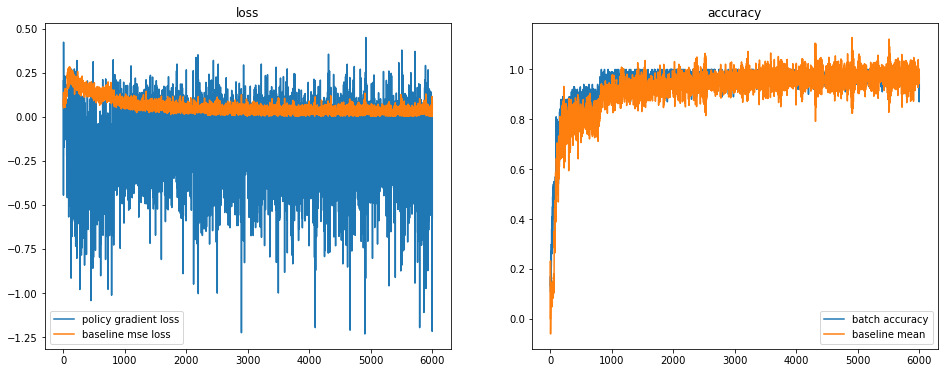

In [9]:
npstats = np.array(stats)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
#plt.plot(npstats[:, 0])
plt.plot(npstats[:, 1])
plt.plot(npstats[:, 2])
#plt.legend(['total loss', 'policy gradient loss', 'baseline mse loss'])
plt.legend(['policy gradient loss', 'baseline mse loss'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(npstats[:, 3])
plt.plot(npstats[:, 4])
plt.legend(['batch accuracy', 'baseline mean'])
#plt.legend(['batch accuracy'])
plt.title('accuracy')

In [10]:
a = np.zeros((x_test.shape[0], 1))
y_pred, baselines = model.predict([x_test, a])
y_pred = np.argmax(y_pred, axis=1)
print(np.mean(y_pred == y_test))

0.9704
